# Introduction

Тестовое задание для стажёра в команду Core ML
DSSM в рекомендациях сообществ

На датасете MovieLens 20M сравните два подхода к построению рекомендаций:

• коллаборативный: используйте только рейтинги. Например SVD-like алгоритмы, ALS, Implicit-ALS.

• коллаборативный + контентный: используйте рейтинги и всю дополнительную информацию о фильмах, имеющуюся в датасете. Например LightFM.

Для выполнения задания:

1    Выберите метрику и обоснуйте этот выбор.

*Для обучения была выбрана метрика precision. В задаче создания рекомендательной системы важно сфокусироваться на FalsePositive, так как из-за большой базы фильмов мы можем позволить системе пропускать некоторые рекомендации в пользу уменьшения количества плохих рекомендаций. Так же, дополнительно были исследованы несколько метрик: recall, miss_rate,	ndcg, map,	arhr, 	coverage*

2    Придумайте и обоснуйте способ разбиения данных на обучение и валидацию.

*Столбцы входной таблицы отсортированы в соответствии с временной меткой (timestamp). В качестве тренировочного набора выбраны строки "из прошлого". В качестве тестового набора выбраны самые "свежие" строки.*

3    Обратите внимание на сходимость обучения и настройку важных гиперпараметров моделей.

*В качестве средства настройки гиперпараметров использовалась библиотека optuna*

4    Оцените статистическую значимость результатов.

*Для всех выбранных метрик метод LightFM показал лучшие результаты по сравнению с SVD.*

5    Выложите на GitHub воспроизводимый код и краткий текстовый отчёт с выводами (можно в формате Jupyter Notebook).

*https://github.com/AlexeyDzyubaP/VK_movies*


Дополнение

За основу данной работы взята тетрадь 
https://github.com/evfro/polara/blob/develop/examples/Comparing%20LightFM%20with%20HybridSVD.ipynb

Использовалась модель оценки холодного старта.

По ходу выполнения данной работы соискатель запустил также  код к статье от Nvidia - построение рекомендательной системы с помощью аутоэнкодера - https://github.com/khanhnamle1994/MetaRec/tree/master/Autoencoders-Experiments/NVIDIA-DeepRec-TensorFlow



### В качестве алгоритмов для сравнения были выбраны LightFM и  алгоритм SVD.

## Downloading and preprocessing data

In [ ]:
!pip install lightfm
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git#egg=polara
!pip install optuna
#!pip install pip
#!pip install scikit-sparse

In [ ]:
import numpy as np
import pandas as pd
#from lightfm.datasets import fetch_stackexchange
from polara.recommender.coldstart.data import ItemColdStartData
from polara.tools.display import print_frames # to print df's side-by-side

Mounting google drive for data extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/VK_movie"
import sys
sys.path.append('/content/drive/My Drive/VK_movie')

Mounted at /content/drive
VK_movie_data


In order to be able to use Polara's functions for data manipulation, we need to convert features (file movie.csv with genres) into dataframe with certain structure

In [ ]:
#Storing the movie information into a pandas dataframe
movies_df = pd.read_csv('drive/My Drive/VK_movie/VK_movie_data/movie.csv')
#Storing the user information into a pandas dataframe
ratings_df = pd.read_csv('drive/My Drive/VK_movie/VK_movie_data/rating.csv', skiprows=0, nrows=30000)
ratings_df = ratings_df.sort_values(by='timestamp')



**The train/test data split is made by time (timestamp). Training is done on older data and testing on newer. This way of splitting the data simulates training on current data to prepare algorithm for future data.**

In [ ]:
test_ratio = 0.2
training_data = ratings_df[:int(ratings_df.shape[0]*(1-test_ratio))]
test_data = ratings_df[int(ratings_df.shape[0]*(1-test_ratio)):]
#print(training_data)
#print(test_data)

training_data = training_data.drop('timestamp', 1)
test_data = test_data.drop('timestamp', 1)

#print(training_data)
#print(test_data)

In [ ]:
#Head is a function that gets the first N rows of a dataframe. N's default is 5.

movies_df = movies_df.drop('title', 1)
movies_df['genres'] = movies_df['genres'].str.split('|')
print(movies_df.head())

item_tags = movies_df


seed = 321 # to be used in data model, LightFM, and optimization routines
training_data = training_data.sample(frac=1, random_state=seed) # shuffle data


training_data.head()

#training_data = training_data.drop('rating', 1)
#test_data = test_data.drop('rating', 1)

item_tags = item_tags.set_index("movieId")

print("---------------------------------------------")
# print(type(test_data["movieId"]))
# print(type(item_tags))
print("--------------test_data-----------------------")
print(test_data.dtypes)
print("---------------item_tags----------------------")
print(item_tags.dtypes)
print("---------------------------------------------")
data_model = ItemColdStartData(
    training_data,
    *training_data.columns, # userid, itemid
    item_features=item_tags,
    seed=seed)

print('data_model = ', data_model)

data_model.test_ratio = 0.05 # take 5% of items as cold (at random)
data_model.prepare()

print_frames([data_model.test.holdout.head(), data_model.test.holdout.tail()])

   movieId                                             genres
0        1  [Adventure, Animation, Children, Comedy, Fantasy]
1        2                     [Adventure, Children, Fantasy]
2        3                                  [Comedy, Romance]
3        4                           [Comedy, Drama, Romance]
4        5                                           [Comedy]
---------------------------------------------
--------------test_data-----------------------
userId       int64
movieId      int64
rating     float64
dtype: object
---------------item_tags----------------------
genres    object
dtype: object
---------------------------------------------
data_model =  ItemColdStartData with Fields(userid='userId', itemid='movieId', feedback='rating')
Preparing data...
Done.
There are 22802 events in the training and 1198 events in the holdout.


,userId,movieId_cold,rating
28637,187,0,3.0
28129,84,0,3.0
25826,91,0,4.0
16943,80,0,2.0
11090,147,0,4.0
,userId,movieId_cold,rating
18553,63,223,3.0
26825,38,224,4.5
16438,34,225,5.0
26759,38,226,3.0


In [ ]:
from polara.recommender.coldstart.models import LightFMItemColdStart

num_threads = 4 # number of parallel threads used by LightFM
max_rank = 100#200 # the max value or latent features used in tuning #################################################################################################

def create_lightfm_model(data_model, item_features, num_threads, seed=None):
    'Prepare LightFM model and fix initial configuration.'
    model = LightFMItemColdStart(data_model, item_features=item_features)
    model.loss = 'warp'
    model.learning_schedule = 'adagrad'
    model.seed = seed
    model.fit_params['num_threads'] = num_threads
    return model

lfm = create_lightfm_model(data_model, item_tags, num_threads, seed)

For automatic hyperparameter optimization we'll be using Optuna framework

In [ ]:
import optuna
#try: # import lightweight progressbar
#    from ipypb import track
#except ImportError: # fallback to default
#    from tqdm.auto import tqdm as track
    
from tqdm.auto import tqdm as track

def evaluate_lightfm(model):
    model._model.user_biases *= 0.0
    return model.evaluate()

def find_target_metric(metrics, target_metric):
    'Convenience function to quickly extract the required metric.'
    for metric in metrics:
        if hasattr(metric, target_metric):
            return getattr(metric, target_metric)

def lightfm_objective(model, target_metric):
    'Objective function factory for optuna trials.'
    def objective(trial):
        # sample hyper-parameter values
        model.rank = trial.suggest_int('rank', 1, max_rank)
        model.item_alpha = trial.suggest_loguniform('item_alpha', 1e-10, 1e-0)
        # train model silently and evaluate
        model.verbose = False
        model.build()
        metrics = evaluate_lightfm(model)
        target = find_target_metric(metrics, target_metric)
        # store trial-specific information for later use
        trial.set_user_attr('epochs', model.fit_params['epochs'])
        trial.set_user_attr('metrics', metrics)
        return target
    return objective
    
# n_trials = {
# # epochs: # trials
#     15: 30,
#     25: 25,
#     50: 20,
#     75: 15,
#     100: 10,
#     150: 5  #5
# }
n_trials = {
# epochs: # trials
    15: 150,
    25: 100,
    50: 70,
    75: 50,
    100: 20,
    150: 10  #5
}
# n_trials = {
# # epochs: # trials
#    # 15: 30,
#    # 25: 25,
#    # 50: 20,
#    # 75: 15,
#    # 100: 10,
#     150: 5  #5
# }

# **LightFM**

In [ ]:
target_metric = 'precision'
objective = lightfm_objective(lfm, target_metric)

study = optuna.create_study(
    direction = 'maximize',
    sampler = optuna.samplers.TPESampler(seed=seed)
)

optuna.logging.disable_default_handler() # do not report progress
for num_epochs, num_trials in track(n_trials.items()):
    lfm.fit_params['epochs'] = num_epochs
    study.optimize(objective, n_trials=num_trials, n_jobs=1, catch=())

#study.optimize(objective, n_trials=5, n_jobs=1, catch=None)

In [ ]:
print(f'The best value of {target_metric}={study.best_value:0.4f} was achieved with '
      f'rank={study.best_params["rank"]} and item_alpha={study.best_params["item_alpha"]:.02e} '
      f'within {study.best_trial.user_attrs["epochs"]} epochs.')


The best value of precision=0.0339 was achieved with rank=51 and item_alpha=3.34e-02 within 75 epochs.


# **SVD**

In [ ]:
import matplotlib.pyplot as plt
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-notebook']) # see plt.style.available

from polara.recommender.coldstart.models import ScaledSVDItemColdStart

svd = ScaledSVDItemColdStart(data_model)

from polara.evaluation.pipelines import find_optimal_config # generic routine for grid-search

def fine_tune_scaledsvd(model, ranks, scale_params, target_metric):
    'Efficiently tuning SVD rank for different scaling parameter values.'
    # descending order helps avoiding model recomputation
    rev_ranks = sorted(ranks, key=lambda x: -x)
    param_grid = [(s, r) for s in scale_params for r in rev_ranks]
    param_names = ('col_scaling', 'rank')
    config, scores = find_optimal_config(
        model, param_grid, param_names, target_metric,
        return_scores=True, force_build=False, iterator=track
    )
    return config, scores

# define the hyper-parameters grid
rank_grid = [1,] + list(range(5, max_rank+1, 5)) # 1, 5, 10, ..., max_rank
scaling_grid = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8] # 1.0 is for PureSVD

# perform tuning

print(rank_grid)
svd_best_config, svd_scores = fine_tune_scaledsvd(
    svd, rank_grid, scaling_grid, target_metric
)





[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


# **Similarity matrix and model simulation**


In [ ]:
from polara.recommender.coldstart.data import ItemColdStartSimilarityData
from polara.lib.similarity import combine_similarity_data

In [ ]:
training_tags = item_tags.reindex(training_data['movieId'].unique(), fill_value=[])
tag_similarity = combine_similarity_data(training_tags, similarity_type='cosine')
print('Similarity matrix density is '
      f'{tag_similarity.nnz / np.prod(tag_similarity.shape):.1%}.')

Similarity matrix density is 46.3%.


This similairty matrix will be fed into the special data model instance, which will take care of providing a consistent on-demand access to similarity information for all dependent recommender models. The input should be in the format of a dictionary, specifiyng types of entities, similarities between them and the corresponding indexing information to decode rows (or columns) of the similarity matrices:

In [ ]:
similarities = {'users': None, # we have no user features
                'items': tag_similarity}
sim_indices = {'users': None,
               'items': training_tags.index}

In [ ]:
data_model_sim = ItemColdStartSimilarityData(
    training_data,
    *training_data.columns,
    relations_matrices=similarities, # new input args
    relations_indices=sim_indices, # new input args
    item_features=item_tags,
    seed=seed
)
print(data_model_sim)

ItemColdStartSimilarityData with Fields(userid='userId', itemid='movieId', feedback='rating')


In [ ]:
data_model_sim.test_ratio = data_model.test_ratio
data_model_sim.prepare()

Preparing data...
Done.
There are 22802 events in the training and 1198 events in the holdout.


<a id="evaluation-of-models"></a>
# Evaluation of models

## Preparing data

In order to disable the Polara's built-in data splitting mechanism, we will employ two handy methods `prepare_training_only` and `set_test_data`. The former will instruct the `data_model` to utilize the whole training data for training without splitting it, and the latter will inject the test data, ensuring its overall consistency. 

In [ ]:
data_model_sim.prepare_training_only()
data_model_sim.set_test_data(holdout=test_data)

Preparing data...
Done.
There are 24000 events in the training and 0 events in the holdout.
47 unique userId entities within 5024 holdout interactions were filtered. Reason: not in the training data.
Done. There are 976 events in the holdout.


Note that in the data splitting provided by the `fetch_stackexchange` function some of the items belong to both the training and the test set. We will ignore it and **treat all items in the testset as cold items**. Recall that in our evaluation setup we generate a list of candidate users for every cold item and than verify the list against the actual interactions present in the holdout.

## Preparing the models to compare

We need to ensure that all models use the same data to avoid any accidental discrepancies in the testing procedure. After that we train the models once again with the values of hyper-parameters, found during the tuning phase, and report the final results. 

### LightFM

In [ ]:
lfm = create_lightfm_model(data_model_sim, item_tags, num_threads, seed)
lfm.rank = study.best_params['rank']
lfm.item_alpha = study.best_params['item_alpha']
lfm.fit_params['epochs'] = study.best_trial.user_attrs['epochs']
lfm.build()

LightFM training time: 7.708s


### SVD

In [ ]:
svd = ScaledSVDItemColdStart(data_model_sim)
svd.col_scaling = svd_best_config['col_scaling']
svd.rank = svd_best_config['rank']
svd.build()

PureSVD(cs)-s training time: 0.015s


## Analyzing the results

Let us first gather all the scores into a single dataframe, which is more convenient.

In [ ]:
from polara.evaluation.evaluation_engine import consolidate_metrics

In [ ]:
all_scores = {
    'SVD (best)': svd.evaluate()
    #'LightFM (best)': evaluate_lightfm(lfm)
    #f'HybridSVD (rank {hsvd.rank})': hsvd.evaluate()
}
all_scores['LightFM (best)'] = evaluate_lightfm(lfm)

In [ ]:
all_scores_df = pd.concat([consolidate_metrics(scores, model, False)
                           for model, scores in all_scores.items()])

During the tuning phase we focused on the `precision` metric. **Since it is important to focus on FalsePositives while building a recomendation system. And while we need to minimize the number of movies recomended incorrectly, we can allow the system to miss some of the movies that otherwise would be recommended. Since this trade-off seems logical in this problem, `precision` will be our metric of choice.**

It is now time to also see other metrics as well, and particularly the `coverage` score. The `coverage` metric characterizes the tendency of an algorithm to generate the same recommendations over and over again and is, therefore, linked to the diversity of recommendations. 

In [ ]:
(all_scores_df
 .dropna(axis=1) # skip irrelevant metrics
 .loc[:, :'coverage']
 .style.bar(subset=[target_metric, 'coverage'], color='#5fba7d', align='mid')
)

,precision,recall,miss_rate,ndcg,map,arhr,coverage
SVD (best),0.015394,0.141397,0.858603,0.059891,0.037292,0.039745,0.411458
LightFM (best),0.028472,0.251157,0.748843,0.156449,0.127833,0.133932,0.531250


As indicated by green horizontal bars in the table above, the standard SVD-based model performs worse both in terms of recommendations accuracy and in terms of diversity.

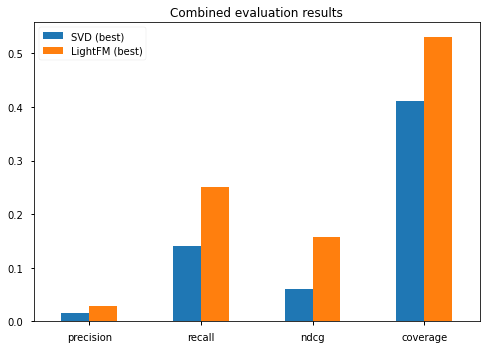

In [ ]:
all_scores_df[['precision', 'recall', 'ndcg', 'coverage']].T.plot.bar(rot=0);
plt.title('Combined evaluation results');

It can be seen that LightFM (collaborative + content) algorithm outperforms SVD (collaborative) in every single metric that we experemented with.